In [1]:
import numpy as np
import csv
import glob
import pandas as pd
from matplotlib import pyplot

# Functions

In [2]:
############ Get Data from CSV File ########### 
def dataGet(data_file):    ## Simulation Data
    """Collects data from csv file
    
    Arguments
    ---------
    data_file : csv file 
        comma-separated values file 
    
    Returns
    -------
    two-dimensional list of strings
    """
    global data   
    raw=open(data_file)
    get_csv=csv.reader(raw)
    data = []
    for line in get_csv:
        data.append(line) 
    return data

def dataCleanDiameter():
    """Cleans Diameter Data (increments of 0.01m along the z-axis) 
    
    Details
    ---------
    Directory must contain all csv files to be read
    
    Returns
    -------
    Three lists of floats: 
        Vel = Velocity [m/s]
        label = file name followed by Z-axis location of diameter
        x_l = position along diameter
    """
    data_file=glob.glob('*.csv')
    temp = []
    for file in data_file:
        data = dataGet(file);
        name_file=file.rsplit('.',1)[0]; 
        data_t = np.transpose(data)
        data_Vel, data_x = data_t[1], data_t[0] 
        i = 0;
        buffer, buffer_x = [], []
        label.append('FILE: '+ name_file)
        for radius in data_x:
            buffer.append(data_Vel[i])
            buffer_x.append(data_x[i])
            if radius == "[Name]":
                buffer_x = buffer_x[4:len(buffer_x)-3]
                buffer_x = [float(item) for item in buffer_x]    
                x_loc.append(buffer_x)                
                buffer = buffer[4:len(buffer)-3]
                buffer = [float(item) for item in buffer]    
                Vel.append(buffer)                 
                label.append(data_x[i+1])
                buffer, buffer_x = [], []
            i+=1        
        buffer_x = buffer_x[4:-1]
        buffer_x = [float(item) for item in buffer_x]    
        x_loc.append(buffer_x)        
        buffer = buffer[4:-1]
        buffer = [float(item) for item in buffer]    
        Vel.append(buffer)
    return Vel,label,x_loc
############ #######################
def dataCleanPlane():
    """Cleans Plane Data (at 0.11[m] for final timestep) 
    
    Details
    ---------
    Directory must contain all csv files to be read
    
    Returns
    -------
    Three lists of floats:
        Vel = Velocity [m/s]
        label = file name followed by Z-axis location of diameter
        x_loc = x component of vertex where velocity is calculated
        y_loc = y component of vertex where velocity is calculated
        z_loc = z component of vertex where velocity is calculated
        area = the sum of sector areas associated with the node
               (a sector area is the portion of area of a face 
               touching a node that can be associated with that node)
    """
    data_file=glob.glob('*.csv')
    temp = []
    for file in data_file:
        data = dataGet(file);
        name_file=file.rsplit('.',1)[0]; 
        data_t = np.transpose(data)
        data_x, data_y, data_z = data_t[0], data_t[1], data_t[2]
        data_Vel, data_area = data_t[3], data_t[4]
        i = 0;
        buffer_Vel, buffer_x,buffer_y,buffer_z,buffer_area = [],[],[],[],[]
        label.append('FILE: '+ name_file)
        for radius in data_x:
            buffer_x.append(data_x[i])
            buffer_y.append(data_y[i])
            buffer_z.append(data_z[i])
            buffer_Vel.append(data_Vel[i])
            buffer_area.append(data_area[i])            
            if radius == "[Name]":
                buffer_x = buffer_x[4:len(buffer_x)-3]
                buffer_x = [float(item) for item in buffer_x]    
                x_loc.append(buffer_x)                
                buffer_y = buffer_y[4:len(buffer_y)-3]
                buffer_y = [float(item) for item in buffer_y]    
                y_loc.append(buffer_y)                
                buffer_z = buffer_z[4:len(buffer_z)-3]
                buffer_z = [float(item) for item in buffer_z]    
                z_loc.append(buffer_z)                
                buffer_Vel = buffer_Vel[4:len(buffer_Vel)-3]
                buffer_Vel = [float(item) for item in buffer_Vel]    
                Vel.append(buffer_Vel)
                buffer_area = buffer_area[4:len(buffer_area)-3]
                buffer_area = [float(item) for item in buffer_area]    
                area.append(buffer_area)                
                label.append(data_x[i+1])
                buffer_Vel, buffer_area,buffer_x,buffer_y,buffer_z = [],[],[],[],[]
            i+=1                
        buffer_x = buffer_x[4:-1]
        buffer_x = [float(item) for item in buffer_x]    
        x_loc.append(buffer_x)  
        buffer_y = buffer_y[4:-1]
        buffer_y = [float(item) for item in buffer_y]    
        y_loc.append(buffer_y)   
        buffer_z = buffer_z[4:-1]
        buffer_z = [float(item) for item in buffer_z]    
        z_loc.append(buffer_z)  
        buffer_Vel = buffer_Vel[4:-1]
        buffer_Vel = [float(item) for item in buffer_Vel]    
        Vel.append(buffer_Vel)
        buffer_area = buffer_area[4:-1]
        buffer_area = [float(item) for item in buffer_area]    
        area.append(buffer_area)
    return Vel,label,x_loc,y_loc,z_loc,area
############ Analytic Solution ################
def analytic_Sol(r,R,pressureGrad):
    """Calculates the analytic solution
    
    Arguments
    ---------
    data_file : csv file 
        comma-separated values file
    r : array of float
        Radius values along the diameter
    R : float
        Radius of the pipe
    pressureGrad : float 
        pressure gradient 
    
    Returns
    -------
    analytic_solution: array of float
    """
    analytic_solution = (R**2-r**2)*(1/(4*1.48e-05))*pressureGrad 
    return analytic_solution
################ L2 Norm  ##################### 
def l2_norm_calc(x_loc, y_loc, Vel, area):
    """Calculates the L2 Norm
    
    Arguments
    ---------
    data_file : csv file 
        comma-separated values file
    r : array of float
        Radius values along the diameter
    R : float
        Radius of the pipe
    pressureGrad : float 
        pressure gradient 
    
    Returns
    -------
    analytic_solution: array of float
    """
    a = 0
    x0, y0 = 0, 0 
    analytic_solution = []
    diff_sqr_areas = []
    error_sum = 0
    for point in x_loc:
        r = np.sqrt((x_loc[a] - 0)**2 + (y_loc[a] - 0)**2)
        asol = (R**2-r**2)*(1/(4*1.48e-05))*pressureGrad
        analytic_solution.append(asol)
        differ = Vel[a] - asol
        diff_sqr = differ**2
        diff_sqr_area = float(diff_sqr) * area[a]
        diff_sqr_areas.append(diff_sqr_area)
        error_sum += diff_sqr_area 
        a+=1    
    l2_norm = np.sqrt(error_sum)
    return l2_norm, analytic_solution,diff_sqr_areas

# Pipe Flow Parameters

In [3]:
length = 0.12              # Pipe Length
R = 0.00227                # Pipe Radius
rho = 1.0                  # Fluid Density
v = 0.5216                 # Uniform Inlet Velocity

Re = rho*v*R*2/(1.48e-05)  # Reynolds number
f = 64/Re                  # Friction Factor
dP = f*length*1*v**2/(2*R*2)   
pressureGrad = dP/length
dPdx = 1.48e-05*4/(R**2)
v_max = v*2                # Maximum Velocity

# Analytic Solution

In [4]:
r1 = np.linspace(-0.00227,0.00227,31)#,1000)
r = np.sqrt(r1**2)  # array how radius changing
analytic_Sol = analytic_Sol(r,R,pressureGrad)

In [14]:
type(r[0])

numpy.float64

# ANSYS - Diameter Data 

In [5]:
cd data\Diameter

C:\Users\Paulina\Desktop\PausWorld\Analysis_ANSYS\Analysis_Meshes-3_Pipeflow_ANSYS\data\Diameter


In [6]:
Vel, label, x_loc = [],[],[]                # Initialize variables
Vel, label, x_loc = dataCleanDiameter()     # Collect Diameter Data

In [7]:
# Collect velocity by mesh: Coarse(16), Med(32), Fine(64)
x_position = x_loc[1]     # Position along diameter at cross section 
Vel_16_z11, Vel_32_z11, Vel_64_z11 = Vel[11], Vel[25], Vel[39]

In [8]:
# Create Dataframes for each mesh table1(Coarse), table2(Med), table3(Fine)
headings = ['x'] + label[1:14]
#transient_16_1s_0.0005_Diameters
table1 = [x_loc[1],Vel[1],Vel[2],Vel[3],Vel[4],
         Vel[5],Vel[6],Vel[7],Vel[8],Vel[9],Vel[10],Vel[11],Vel[12],Vel[13]]
df1 = pd.DataFrame(table1)
df1 = df1.transpose()
df1.columns = headings

#transient_32_0.3s_0.0005_Diameters
table2 = [x_loc[2],Vel[15],Vel[16],Vel[17],Vel[18],Vel[19],
         Vel[20],Vel[21],Vel[22],Vel[23],Vel[24],Vel[25],Vel[26],Vel[27]]
df2 = pd.DataFrame(table2)
df2 = df2.transpose()
df2.columns = headings

#transient_64_0.3s_0.00025_Diameters
table3 = [x_loc[3],Vel[28],Vel[29],Vel[30],Vel[31],Vel[32],
         Vel[33],Vel[34],Vel[35],Vel[36],Vel[37],Vel[38],Vel[39],Vel[40]]
df3 = pd.DataFrame(table3)
df3 = df3.transpose()
df3.columns = headings

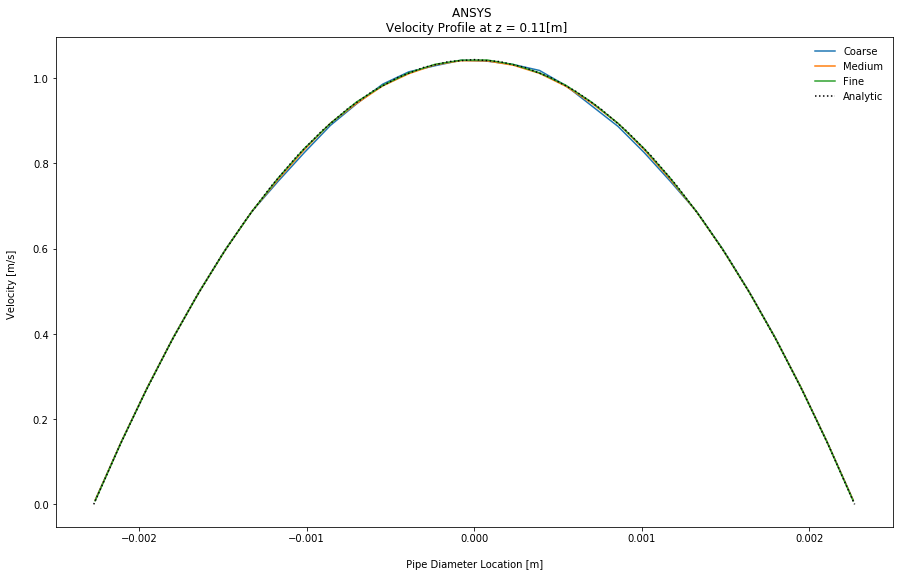

In [9]:
pyplot.figure(figsize=(15,9))
pyplot.plot(df1['x'],df1['Diameter11 at Diameter11'] ,label="Coarse" )
pyplot.plot(df2['x'],df2['Diameter11 at Diameter11'] ,label="Medium" )
pyplot.plot(df3['x'],df3['Diameter11 at Diameter11'] ,label="Fine" )
pyplot.plot(r1,analytic_Sol, label = 'Analytic',color='black',linestyle=':')
pyplot.xlabel('\n Pipe Diameter Location [m] \n')
pyplot.ylabel('Velocity [m/s] \n')
pyplot.title('ANSYS \n Velocity Profile at z = 0.11[m]')
pyplot.legend(loc="upper right");
pyplot.legend(loc="upper right", frameon = False);
pyplot.savefig('Vel_Mesh16-32-64_ANSYS.png',dpi =1000)

----

# ANSYS - Plane Data 

In [10]:
cd ..\Plane_11

C:\Users\Paulina\Desktop\PausWorld\Analysis_ANSYS\Analysis_Meshes-3_Pipeflow_ANSYS\data\Plane_11


In [11]:
Vel,label, x_loc, y_loc, z_loc, area = [], [], [], [], [], []
# Collect & Clean All data
Vel,label, x_loc, y_loc, z_loc, area = dataCleanPlane()

In [12]:
# Calculate L2 Norm
l2_norm_16, analytic_solution_16,diff_16 = l2_norm_calc(x_loc[1], y_loc[1], Vel[1], area[1])
l2_norm_32, analytic_solution_32,diff_32 = l2_norm_calc(x_loc[3], y_loc[3], Vel[3], area[3])
l2_norm_64, analytic_solution_64,diff_64 = l2_norm_calc(x_loc[5], y_loc[5], Vel[5], area[5])
print(' l2_norm_16 =',l2_norm_16,'\n','l2_norm_32 =',l2_norm_32,'\n','l2_norm_64 =',l2_norm_64)

 l2_norm_16 = 1.427405027665904e-05 
 l2_norm_32 = 5.0785806969720265e-06 
 l2_norm_64 = 1.6882401183998343e-06


In [12]:
type(x_loc[1][0])

float

In [13]:
#Data Frames for each mesh: Coarse(16),Med(32),Fine(64)
headings = ['x','y','Error']

#transient_16_1s_0.0005_Diameters
table16 = [x_loc[1],y_loc[1],diff_16]
df16 = pd.DataFrame(table16)
df16 = df16.transpose()
df16.columns = headings

#transient_32_1s_0.0005_Diameters
table32 = [x_loc[3],y_loc[3],diff_32]
df32 = pd.DataFrame(table32)
df32 = df32.transpose()
df32.columns = headings

#transient_64_1s_0.0005_Diameters
table64 = [x_loc[5],y_loc[5],diff_64]
df64 = pd.DataFrame(table64)
df64 = df64.transpose()
df64.columns = headings

## LogLog of Errors

In [14]:
Error_Openfoam = np.array([9.421e-05,2.721e-05,1.129e-05])
Error_Ansys = np.array([l2_norm_16,l2_norm_32,l2_norm_64])
mesh_elem = np.array([16,32,64])  # or [32040,78840,630720]

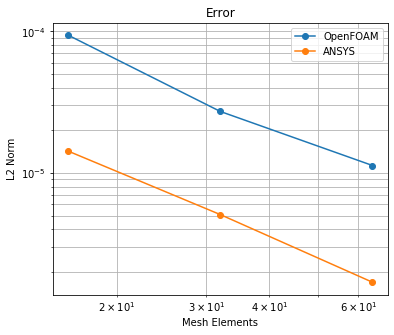

In [15]:
pyplot.figure(figsize=[6,5])
pyplot.title('Error')
pyplot.xlabel('Mesh Elements')
pyplot.ylabel('L2 Norm')
pyplot.loglog(mesh_elem,Error_Openfoam,'-o', label = 'OpenFOAM')
pyplot.loglog(mesh_elem,Error_Ansys,'-o', label = 'ANSYS')
pyplot.legend()
pyplot.grid(True, which="both", ls="-")